In [4]:
import os
import os.path as osp
import glob
import logging
import random
import json
from pathlib import Path

import cv2
import numpy as np

import sys
sys.path.append("/lustre/fsw/portfolios/nvr/users/ymingli/projects/VideoActionModel/3DV/vggt/training/")
from data.dataset_util import *
from data.base_dataset import BaseDataset

from hydra import initialize, compose


In [5]:
class MVSSynthDataset(BaseDataset):
    '''
    Sequence Structure:
        <root>/<scene index>/depths/<img index.exr>
        <root>/<scene index>/images/<img index.png>
        <root>/<scene index>/poses/<img index.json>: cx,cy,extrinsics, fx,fy 
    '''
    def __init__(
        self,
        common_conf,
        split: str = "train",
        MVSSynth_DIR: str = "/lustre/fsw/portfolios/nvr/projects/nvr_av_verifvalid/users/ymingli/datasets/MVS-Synth/GTAV_720/",
        min_num_images: int = 24,
        len_train: int = 100000,
        len_test: int = 10000,
        expand_ratio: int = 8,
    ):
        super().__init__(common_conf=common_conf)
        self.debug = common_conf.debug
        self.training = common_conf.training
        self.get_nearby = common_conf.get_nearby
        self.inside_random = common_conf.inside_random
        self.allow_duplicate_img = common_conf.allow_duplicate_img

        self.expand_ratio = expand_ratio
        self.MVSSynth_DIR = MVSSynth_DIR.rstrip("/")
        self.min_num_images = min_num_images


        if split == "train":
            self.len_train = len_train
        elif split == "test":
            self.len_train = len_test
        else:
            raise ValueError(f"Invalid split: {split}")
            
        logging.info(f"MVSSynth Dataset Dir = {self.MVSSynth_DIR}")

        # Load sequence list(from 0000 to 0119)          
        sequence_list = [p for p in glob.glob(osp.join(self.MVSSynth_DIR, "*")) if osp.isdir(p)]
        sequence_list = sorted(sequence_list)

        # Get seq_lengths from file
        seq_len_file = osp.join(self.MVSSynth_DIR, "num_images.json")
        with open(seq_len_file) as f:
            seq_lengths = json.load(f)
        if len(seq_lengths) != len(sequence_list):
            logging.warning(f"seq_lengths ({len(seq_lengths)}) != sequence_list length ({len(sequence_list)})")

        # Filter sequences less than 24
        filtered_list = []
        sequence_lengths = []
        for seq, num_image in zip(sequence_list, seq_lengths):
            num_images = int(num_image)
            if num_images >= self.min_num_images:
                filtered_list.append(seq)
                sequence_lengths.append(num_images)

        self.sequence_list = filtered_list
        self.sequence_list_len = len(self.sequence_list)
        self.save_seq_stats(self.sequence_list, seq_lengths, self.__class__.__name__)

        status = "Training" if self.training else "Testing"
        logging.info(f"{status}: MVSSynth scene count: {self.sequence_list_len}")
        logging.info(f"{status}: MVSSynth dataset length: {len(self)}")

    def read_mvs_synth_depth(self, depth_path: str) -> np.ndarray:
        """
        Read EXR depth map specifically for MVS-Synth dataset.
        
        MVS-Synth depth files are single-channel EXR files with:
        - Channels: Y: HALF
        - Size: 1280x720
        
        Args:
            depth_path (str): Path to the EXR depth file
            
        Returns:
            np.ndarray: Depth map as float32 array with shape (H, W)
        """
        img = cv2.imread(depth_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        
        if img is None:
            raise ValueError(f"Failed to load EXR file {depth_path}. Make sure OPENCV_IO_ENABLE_OPENEXR=1 is set.")
        
        # Handle single-channel vs multi-channel EXR files
        if len(img.shape) == 3:
            # Multi-channel image, take the first channel (Y channel)
            depth_map = img[..., 0]
        elif len(img.shape) == 2: # in fact the exr just has one Y channel 
            # Single-channel image, use as is
            depth_map = img
        else:
            raise ValueError(f"Unexpected image shape {img.shape} for EXR file {depth_path}")
        
        # Filter out invalid depth values
        depth_map[depth_map > 1e9] = 0.0
        depth_map[~np.isfinite(depth_map)] = 0.0
        
        return depth_map.astype(np.float32)

    def get_data(
        self,
        seq_index: int = None,
        img_per_seq: int = 24,
        seq_name: str = None,   
        ids: list = None,       
        aspect_ratio: float = 1.0,
    ) -> dict:  
        if self.inside_random and self.training:
            seq_index = random.randint(0, self.sequence_list_len - 1)

        if seq_name is None:
            seq_name = self.sequence_list[seq_index]

        # Determine number of frames by counting image files
        img_dir = osp.join(seq_name, 'images')
        img_files = sorted(glob.glob(osp.join(img_dir, '*.png')))
        num_images = len(img_files)

        if ids is None:
            ids = np.random.choice(num_images, img_per_seq, replace=self.allow_duplicate_img)

        if self.get_nearby:
            ids = self.get_nearby_ids(ids, num_images, expand_ratio=self.expand_ratio)

        target_image_shape = self.get_target_shape(aspect_ratio)

        images, depths = [], []
        extrinsics, intrinsics = [], []
        cam_points, world_points = [], []
        point_masks, original_sizes = [], []

        for local_idx in ids:
            # 4 digit path format: img_index.*
            stem = f"{local_idx:04d}"
            image_filepath = osp.join(seq_name, 'images', f'{stem}.png')
            depth_filepath = osp.join(seq_name, 'depths', f'{stem}.exr')
            pose_filepath = osp.join(seq_name, 'poses', f'{stem}.json')

            image = read_image_cv2(image_filepath)

            # read exr depth map using specialized MVS-Synth reader
            # Channels: Y: HALF
            # Size: 1280x720
            depth_map = self.read_mvs_synth_depth(depth_filepath)
            depth_map = threshold_depth_map(depth_map)  # not in meters

            original_size = np.array(image.shape[:2])

            # load pose from json
            with open(pose_filepath, 'r') as f:
                pose_data = json.load(f)
            cx = pose_data['c_x']
            cy = pose_data['c_y']
            fx = pose_data['f_x']
            fy = pose_data['f_y']
            extrinsic = np.array(pose_data['extrinsic'], dtype=np.float32)  # 4x4 matrix

            extri_opencv = extrinsic[:3, :]  # camera-from-world (OpenCV), 3x4
            intri_opencv = np.array([
                [fx, 0, cx], 
                [0, fy, cy], 
                [0, 0, 1]], dtype=np.float32)

            (
                image,
                depth_map,
                extri_opencv,
                intri_opencv,
                world_coords_points,
                cam_coords_points,
                point_mask,
                _,
            ) = self.process_one_image(
                image,
                depth_map,
                extri_opencv,
                intri_opencv,
                original_size,
                target_image_shape,
                filepath=image_filepath,
            )

            if (image.shape[:2] != target_image_shape).any():
                logging.error(f"Wrong shape for {seq_name}: expected {target_image_shape}, got {image.shape[:2]}")
                continue

            images.append(image)
            depths.append(depth_map)
            extrinsics.append(extri_opencv)
            intrinsics.append(intri_opencv)
            cam_points.append(cam_coords_points)
            world_points.append(world_coords_points)
            point_masks.append(point_mask)
            original_sizes.append(original_size)
        
        set_name = "MVSSynth"
        batch = {
            "seq_name": set_name + "_" + Path(seq_name).name,
            "ids": ids,
            "frame_num": len(extrinsics),
            "images": images,
            "depths": depths,
            "extrinsics": extrinsics,   
            "intrinsics": intrinsics,   
            "cam_points": cam_points,
            "world_points": world_points,
            "point_masks": point_masks,
            "original_sizes": original_sizes,
        }
        return batch

/lustre/fsw/portfolios/nvr/users/ymingli/miniconda3/envs/vggt/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'default': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


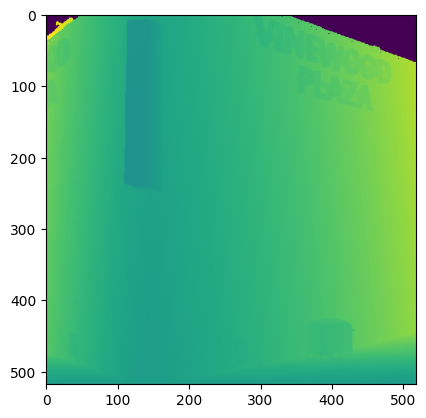

In [7]:
# In training folder, run python -m data.datasets.MVS-Synth
if __name__ == "__main__":
    with initialize(version_base=None, config_path="../../config"):
        cfg = compose(config_name="default")
    dataset = MVSSynthDataset(common_conf=cfg.data.train.common_config, split="train", MVSSynth_DIR="/lustre/fsw/portfolios/nvr/projects/nvr_av_verifvalid/users/ymingli/datasets/MVS-Synth/GTAV_720")
    db = dataset.get_data(seq_index=0)
    image = db['depths'][0]
    import matplotlib.pyplot as plt
    plt.imshow(image)
    plt.show()